# Step 1: Load, normalise, and filter LLM data
### This turns it into the dataframe llm_data

In [6]:
import pandas as pd
import sqlite3
import yaml
from datetime import datetime

# Load configuration
with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)

# Connect to the SQLite database
conn = sqlite3.connect(config['db_path'])

# Read data from the 'events' table
query = "SELECT * FROM events"
llm_data = pd.read_sql_query(query, conn)

# Close the database connection
conn.close()

# Normalize the date column
llm_data['normalized_date'] = pd.to_datetime(llm_data['date'], errors='coerce')

# Remove rows with invalid dates
llm_data = llm_data[llm_data['normalized_date'].notna()]

# Normalize the 'name' field
llm_data['normalized_name'] = llm_data['name'].str.strip().str.lower()

# Identify and remove duplicates, understood as having the same name and date
duplicates = llm_data.duplicated(subset=['normalized_date', 'normalized_name'], keep=False)
unique_data = llm_data[~duplicates]
duplicate_data = llm_data[duplicates]

# Combine discarded entries
combined_discards = pd.concat([duplicate_data, llm_data[llm_data['normalized_date'].isna()]])

# Save the discarded entries
today_date = pd.Timestamp.now().strftime('%Y-%m-%d')
combined_discards.to_json(f'Cleaning/{today_date}_rejected_step_1.json', orient='records', force_ascii=False)

# Get the columns to compare from the config
columns_to_compare = config['columns_to_compare']
llm_data = unique_data[columns_to_compare].copy()

# Normalize text in all columns
def normalize_text(text):
    if pd.isna(text) or str(text).strip().lower() == "unknown":
        return ""
    return ' '.join(str(text).lower().split())

llm_data = llm_data.applymap(normalize_text)

# Display the result
display(llm_data.head(5))

/var/folders/w7/w77lxml93h14ccccvjptbbnc0000gn/T/ipykernel_74726/3376605712.py:21: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  llm_data['normalized_date'] = pd.to_datetime(llm_data['date'], errors='coerce')
/var/folders/w7/w77lxml93h14ccccvjptbbnc0000gn/T/ipykernel_74726/3376605712.py:51: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  llm_data = llm_data.applymap(normalize_text)


,normalized_date,name,venue
0,1908-02-15 00:00:00,nior konsert,svea-salen
1,1908-02-17 00:00:00,kalle- och afton-konsert,arbetareinstitutet
2,1908-02-16 00:00:00,folk-konsert,nan


# Import Human Data

In [11]:
from datetime import datetime

human_data = pd.read_excel(config['Stockholm_Concert_Database_Path'])

# Make all column names lowercase
human_data.columns = [col.lower() for col in human_data.columns]

# Rename the columns in the human data to match the events table
human_data = human_data.rename(columns={
    'konsert_datum': 'date',
    'konsert_namn': 'name',
    'lokal_namn': 'venue',
    'arrangör': 'organiser',
})

# Function to convert date objects in the human data
def convert_human_dates(date_obj):
    if isinstance(date_obj, str):
        # If the input is a string, parse it
        try:
            date = datetime.strptime(date_obj, "%Y-%m-%d")
        except ValueError:
            # Return None if the input string is invalid
            return None
    elif isinstance(date_obj, pd.Timestamp):
        # If the input is a Timestamp object, convert it to datetime
        date = date_obj.to_pydatetime()
    else:
        # Return None if the input is neither a string nor a Timestamp
        return None
    
    # Convert to the desired format
    formatted_date = date.strftime("%Y-%m-%d %H:%M:%S")
    
    return formatted_date

# Normalize the date column by applying the convert_human_dates function
human_data['normalized_date'] = human_data['date'].apply(convert_human_dates)

# Drop the original 'date' column
human_data = human_data.drop('date', axis=1)

# Remove rows with invalid dates in the 'normalized_date' column
human_data = human_data[human_data['normalized_date'].notna()]

# Normalize text columns
text_columns = ['name', 'venue', 'organiser']
for col in text_columns:
    human_data[f'normalized_{col}'] = human_data[col].apply(normalize_text)

# Display the result
display(human_data.head(10))

,konsert_id,name,venue,konsert_biljettpris,summaförannons/program,summaförrecension,summaförantalförkonsert_verk_id,organiser,konserttyp_namn,månad,år,dag,månadnr,lokal_namn_eng,konserttyp_namn_eng,producer,normalized_date,normalized_name,normalized_venue,normalized_organiser
0,2528,Brüssel-kvartetten Beethovenafton,Kungliga musikaliska akademiens lokal,NaN,NaN,NaN,NaN,Brüssel-stråkkvartetten,Kammarmusikkonsert,JANUARY,1908,Thursday,1,NaN,Chamber music concert,Brüssel-stråkkvartetten - Brussels String Quartet,1908-01-02 00:00:00,brüssel-kvartetten beethovenafton,kungliga musikaliska akademiens lokal,brüssel-stråkkvartetten
1,2509,1:sta säsångskonsert: Nordisk afton,Hotel Continentals festsal,"2kr (numrerade platser), 1:50kre och 1kr",2.0,NaN,14.0,"Gellin, Eduard",Konsert,JANUARY,1908,Sunday,1,NaN,Concert,"Gellin, Eduard",1908-01-05 00:00:00,1:sta säsångskonsert: nordisk afton,hotel continentals festsal,"gellin, eduard"
2,2521,Afskedskonsert,Immanuelskyrkan,NaN,NaN,2.0,NaN,"Bohlin, Carl. Direktör",Kyrkokonsert,JANUARY,1908,Sunday,1,NaN,Church concert,"Bohlin, Carl. Director",1908-01-05 00:00:00,afskedskonsert,immanuelskyrkan,"bohlin, carl. direktör"
3,2516,Folk-konsert,"Arbetare-institutet, Klara Norra Kyrkogata 8",NaN,2.0,NaN,5.0,NaN,Folkkonsert,JANUARY,1908,Sunday,1,NaN,Folk concert,NaN,1908-01-05 00:00:00,folk-konsert,"arbetare-institutet, klara norra kyrkogata 8",
4,2515,Populärkonsert,Vetenskapsakademiens hörsal,NaN,NaN,NaN,NaN,"Hansson, Axel",Populärkonsert,JANUARY,1908,Sunday,1,NaN,Popular concert,"Hansson, Axel",1908-01-05 00:00:00,populärkonsert,vetenskapsakademiens hörsal,"hansson, axel"
5,2510,2:a populära Symfoni-matinéen,Berns salong,"1kr till salongen, 1:50kr till läktaren",NaN,2.0,NaN,Berns,Konsert,JANUARY,1908,Monday,1,NaN,Concert,Berns,1908-01-06 00:00:00,2:a populära symfoni-matinéen,berns salong,berns
6,2511,Jul-fest med Bal,Grand Restaurant Nationals stora salong,"1:25kr herre, 1kr da, 50öre barn",NaN,NaN,NaN,Lj. B.,Bal,JANUARY,1908,Monday,1,NaN,Ball,Lj. B.,1908-01-06 00:00:00,jul-fest med bal,grand restaurant nationals stora salong,lj. b.
7,2517,Populär soaré,Vetenskapsakademiens hörsal,"1kr reserverad plats, 75öre övriga platser",1.0,NaN,9.0,"Dahlberg, Erik",Populärkonsert,JANUARY,1908,Monday,1,NaN,Popular concert,"Dahlberg, Erik",1908-01-06 00:00:00,populär soaré,vetenskapsakademiens hörsal,"dahlberg, erik"
8,2519,Populär soaré,"Arbetare-institutet, Klara Norra Kyrkogata 8","1kr reserverad plats, 75öre, 50öre",NaN,NaN,NaN,Arbetareinstitutet,Populärkonsert,JANUARY,1908,Monday,1,NaN,Popular concert,Arbetareinstitutet - Workers' Institute,1908-01-06 00:00:00,populär soaré,"arbetare-institutet, klara norra kyrkogata 8",arbetareinstitutet
9,2512,2:a kammarmusikkonsert: Brahmsafton,Vetenskapsakademiens hörsal,"3kr numrerade, 2:50kr onumrerade",3.0,2.0,3.0,Aulinkvartetten,Kammarmusikkonsert,JANUARY,1908,Tuesday,1,NaN,Chamber music concert,Aulinkvartetten - Aulin Quartet,1908-01-07 00:00:00,2:a kammarmusikkonsert: brahmsafton,vetenskapsakademiens hörsal,aulinkvartetten


In [12]:
# Dropping everything in human data except the required columns

# Create a list of required columns
required_columns = columns_to_compare + ['normalized_date']

# Drop all columns except for the required columns
human_data = human_data[required_columns]

human_data = human_data.loc[:, ~human_data.columns.duplicated()]


# Display the result
display(human_data.head(5))


,normalized_date,name,venue
0,1908-01-02 00:00:00,Brüssel-kvartetten Beethovenafton,Kungliga musikaliska akademiens lokal
1,1908-01-05 00:00:00,1:sta säsångskonsert: Nordisk afton,Hotel Continentals festsal
2,1908-01-05 00:00:00,Afskedskonsert,Immanuelskyrkan
3,1908-01-05 00:00:00,Folk-konsert,"Arbetare-institutet, Klara Norra Kyrkogata 8"
4,1908-01-05 00:00:00,Populärkonsert,Vetenskapsakademiens hörsal


In [13]:
print(llm_data.columns.duplicated())


[False False False]


# Cleaning the two datasets for comparison

In [14]:
from IPython.display import display

import pandas as pd
import numpy as np

# Ensure both DataFrames only have the columns to compare and normalized_date
required_columns = columns_to_compare + ['normalized_date']
assert all(col in llm_data.columns for col in required_columns), "Missing required columns in llm_data"
assert all(col in human_data.columns for col in required_columns), "Missing required columns in human_data"

llm_data = llm_data[required_columns]
human_data = human_data[required_columns]

# Remove duplicate columns if they exist
llm_data = llm_data.loc[:, ~llm_data.columns.duplicated()]
human_data = human_data.loc[:, ~human_data.columns.duplicated()]

# Ensure the 'normalized_date' column is 1-dimensional and properly formatted
llm_data['normalized_date'] = pd.to_datetime(llm_data['normalized_date'], errors='coerce')
human_data['normalized_date'] = pd.to_datetime(human_data['normalized_date'], errors='coerce')

# Drop rows with invalid 'normalized_date' values
human_data = human_data.dropna(subset=['normalized_date'])

display(llm_data)
display(human_data)


,normalized_date,name,venue
0,1908-02-15,nior konsert,svea-salen
1,1908-02-17,kalle- och afton-konsert,arbetareinstitutet
2,1908-02-16,folk-konsert,nan


,normalized_date,name,venue
0,1908-01-02,Brüssel-kvartetten Beethovenafton,Kungliga musikaliska akademiens lokal
1,1908-01-05,1:sta säsångskonsert: Nordisk afton,Hotel Continentals festsal
2,1908-01-05,Afskedskonsert,Immanuelskyrkan
3,1908-01-05,Folk-konsert,"Arbetare-institutet, Klara Norra Kyrkogata 8"
4,1908-01-05,Populärkonsert,Vetenskapsakademiens hörsal
...,...,...,...
509,1908-12-26,Familje-soiré,Vetenskapsakademiens hörsal
510,1908-12-26,Populär soaré,"Arbetare-institutet, Klara Norra Kyrkogata 8"
511,1908-12-27,Populär soaré,"Arbetare-institutet, Klara Norra Kyrkogata 8"
512,1908-12-31,Nyårsvaka å Runan,NaN


# Human_Data: Comparing every row of human_data to LLM to find best match

In [15]:
from fuzzywuzzy import fuzz
# Function to compute the maximum fuzzy match score and index for a given row against a group of rows
def compute_fuzzy_match_with_date(row1_str, date_group, group_indices):
    max_score = 0
    best_index = None
    for idx, row2_str in zip(group_indices, date_group):
        score = fuzz.token_set_ratio(row1_str, row2_str)
        if score > max_score:
            max_score = score
            best_index = idx
    return (max_score if max_score > 0 else np.nan, best_index)

# Preprocess llm_data to group by 'normalized_date'
date_groups = llm_data.groupby('normalized_date').apply(
    lambda df: (
        [' '.join(map(str, [row[col] for col in columns_to_compare if col in row])) for _, row in df.iterrows()],
        df.index.tolist()
    )
)

# Compute match scores and best match indices for each row in human_data
human_data['match_score'], human_data['best_match_index'] = zip(*human_data.apply(
    lambda row: compute_fuzzy_match_with_date(
        ' '.join(map(str, [row[col] for col in columns_to_compare if col in row])),
        *date_groups.get(row['normalized_date'], ([], []))
    ),
    axis=1
))

# Sort human_data by 'match_score' in descending order
sorted_human_data = human_data.sort_values(by='match_score', ascending=False)

# Display the relevalt columns
display(sorted_human_data[['match_score', 'best_match_index']])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
/var/folders/w7/w77lxml93h14ccccvjptbbnc0000gn/T/ipykernel_74726/513110085.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  date_groups = llm_data.groupby('normalized_date').apply(


,match_score,best_match_index
88,82.0,2.0
87,64.0,2.0
86,60.0,2.0
89,60.0,2.0
92,55.0,1.0
...,...,...
509,NaN,NaN
510,NaN,NaN
511,NaN,NaN
512,NaN,NaN


# Statistics for the Human_data, detailing how close a match in the LLM data has been found

#### Best score so far is 69.75 achieved by comparing 'normalized_date', 'normalized_konsert_namn', 'lokal_namn', so if it's lower than that then you better have a good reason

Average of 'match_score': 57.333333333333336
25th Percentile of 'match_score': 52.0
Median (50th Percentile) of 'match_score': 55.0
75th Percentile of 'match_score': 60.0
Median of 'match' score': 55.0
Standard Deviation of 'match_score': 11.357816691600547


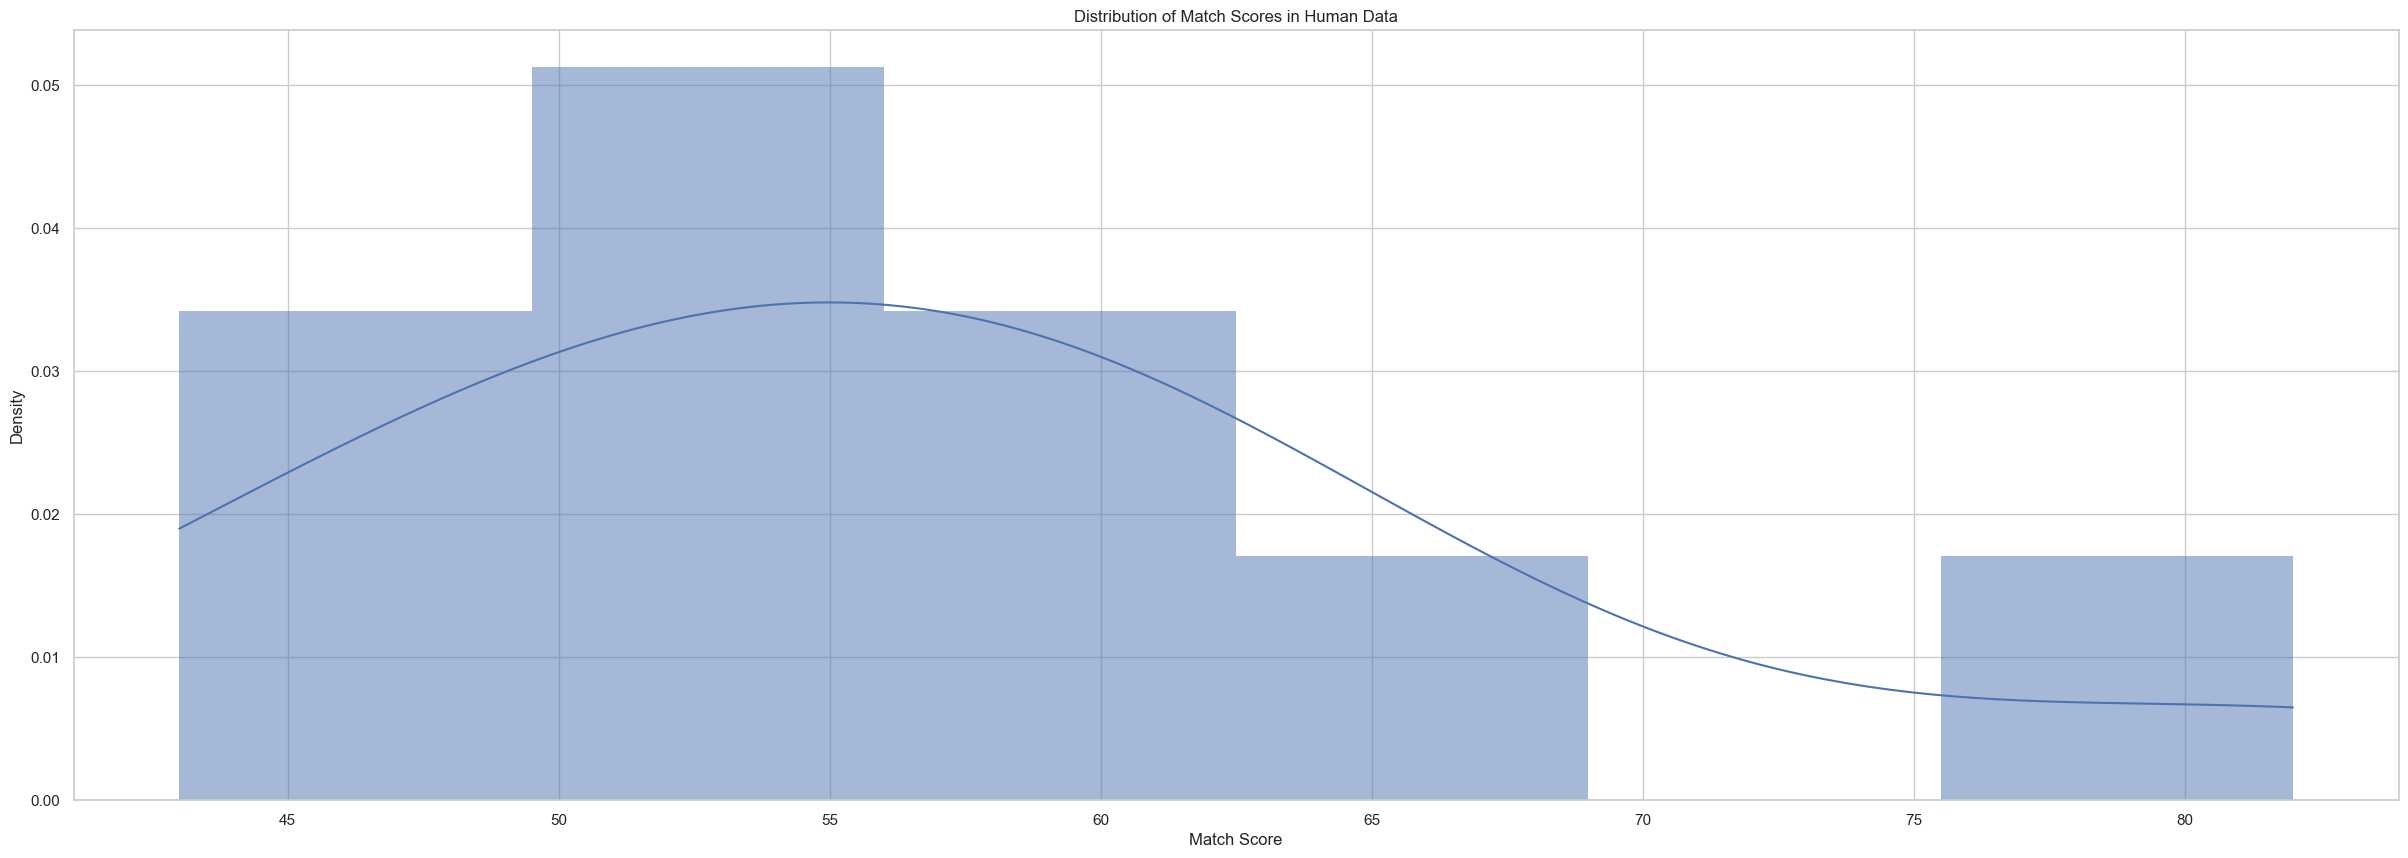

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the standard deviation of the 'match_score' column in human_data
std_deviation = human_data['match_score'].std()

# Calculate the average of the 'match_score' column in human_data
average_match_score = human_data['match_score'].mean()

# Print the average match score
print("Average of 'match_score':", average_match_score)

# Calculate specific percentiles of the 'match_score' column in human_data
percentile_25 = human_data['match_score'].quantile(0.25)
percentile_50 = human_data['match_score'].quantile(0.50)  # This is the median
percentile_75 = human_data['match_score'].quantile(0.75)

# Print the percentile values
print("25th Percentile of 'match_score':", percentile_25)
print("Median (50th Percentile) of 'match_score':", percentile_50)
print("75th Percentile of 'match_score':", percentile_75)

# Calculate the median of the 'match_score' column in human_data
median_match_score = human_data['match_score'].median()

# Print the median match score
print("Median of 'match' score':", median_match_score)

# Print the standard deviation
print("Standard Deviation of 'match_score':", std_deviation)

# Setting the style and color palette of the plot
sns.set(style="whitegrid")

# Creating the density plot for match_score distribution in human_data
plt.figure(figsize=(30, 10))
sns.histplot(human_data['match_score'], kde=True, stat="density", linewidth=0)

# Adding titles and labels
plt.title('Distribution of Match Scores in Human Data')
plt.xlabel('Match Score')
plt.ylabel('Density')

# Display the plot
plt.show()
